# Computing Separable Bk Estimates

This notebook describes the usage of the `separate-bk` code. In particular, we demonstrate how to produce the input datafiles, how to plot the output reconstructed shapes, and how to interface them with the CMB estimator [PolySpec](https://github.com/oliverphilcox/PolySpec).

In [1]:
### IMPORTS
%pylab inline
from sep_bk_nn import SepBKNN
import torch, scipy

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Generating the input file

Here we'll demonstrate how to construct the input datafile used by `separate-bk`. This should contain a list of wavenumbers and shapes, in the form $\{k_1,k_2,k_3,S(k_1,k_2,k_3)\}$. The shape function is usually assumed to be permutation invariant, normalized to one in equilateral configurations, and scale-invariant (though scale-invariance is not assumed by the code). 

The $k_i$ points should span the full $k$-range of interest, and obey the triangle conditions, *i.e.* $|k_1-k_2|\leq k_3\leq k_1+k_2$. To avoid degeneracies, we also restrict to $k_1\leq k_2\leq k_3$. Practically, we find that using a linearly-spaced grid in $k_i$ leads to efficient training of the estimator; to help with the squeezed limits, we supplement this with some additional logarithmically-spaced points at low-$k$. 

Below, we'll show an example for the equilateral shape function. In many practical settings, we would want to use a numerically computed shape directly (or interpolate it from a grid of points). Here, we use the known functional form corresponding to $f_{\rm NL}^{\rm equil}$.

In [2]:
def shape_function(k1, k2, k3, type='equil'):
    """Compute the shape function for the local, equilateral, and orthogonal shapes.
    
    Here, we assume the ns = 1 (de Sitter) limit for simplicity."""

    if type=='local':
        return (k1**2/k2/k3 + k2**2/k1/k3+k3**2/k1/k2)/3.

    elif type=='equil':
        term1 = -(k3**2/(k1*k2) + k1**2/(k2*k3) + k2**2/(k3*k1))
        term2 = -2
        term3 = (k1/k3 + k2/k1 + k3/k2 + k1/k2 + k2/k3 + k3/k1)
        return term1+term2+term3

    elif type=='ortho':
        term1 = -3*(k3**2/(k1*k2) + k1**2/(k2*k3) + k2**2/(k3*k1))
        term2 = -8
        term3 = 3*(k1/k3 + k2/k1 + k3/k2 + k1/k2 + k2/k3 + k3/k1)
        return term1 + term2 + term3

    else:
        raise Exception()

In [3]:
# Generate a test-set for Planck
kmin = 2e-5 # in 1/Mpc
kmax = 0.2
n_points_k1 = 150

# Define a 1D k-grid (using log sampling at low-k)
kk =  list(np.geomspace(kmin,10*kmin,n_points_k1//10))
kk += list(np.linspace(10*kmin,kmax,n_points_k1))

# Define a 3D k-grid of k1, k2, k3
k1s,k2s,k3s = np.meshgrid(kk,kk,kk)

# Apply triangle conditions
# We also restrict to k1<=k2<=k3 to avoid degeneracies
filt = (np.abs(k1s-k2s)<=k3s)*(k3s<=k1s+k2s)*(k1s<=k2s)*(k2s<=k3s)
kk1s = k1s[filt]
kk2s = k2s[filt]
kk3s = k3s[filt]

# Compute dataset
shapes = shape_function(kk1s,kk2s,kk3s,'equil')
dataset = np.vstack([kk1s,kk2s,kk3s,shapes]).T
print("Using %d datapoints"%len(dataset))

# Save output
shape_file = "notebook_data/planck_template_equil.txt"
np.savetxt(shape_file, dataset)

Using 292380 datapoints


## 2. Running `separate-bk`

Given the input datafile, we can run the main code. First, we create a `yaml` file which links to the template constructed above, also specifying the output directories.

In [4]:
# Copy fiducial yaml file, replacing the dataset
with open("experiment_fiducial.yaml", "r") as infile:
    with open("notebook_data/experiment_equil.yaml","w+") as outfile:
        lines = infile.readlines()
        for line in lines:
            if line.strip().startswith("datafile:"):
                outfile.write(f"  datafile: '{shape_file}'\n")
            elif line.strip().startswith("model_dir:"):
                outfile.write(f"  model_dir: 'models/equil'\n")
            elif line.strip().startswith("results_dir:"):
                outfile.write(f"  results_dir: 'results/equil'\n")
            else:
                outfile.write(line)

Next, we run the code on the command line via:
```console
    python main.py --config notebook_data/experiment_equil.yaml [--test_id 0]
```
where `test_id` specifies which of the test set-ups to use (as specified in the YAML file, with all tests run by default). The code runs significantly faster if GPUs are available. 

The output model will be saved in the `models/equil` directory that we specified above. When each run is complete, the code will print the optimized cosine between the true and approximated bispectrum model.

## 3. Visualizing the outputs

Now, we reconstruct the model outputs. The output functions and weights are in pytorch, so there's a little bit of wrangling to read them into numpy.

In [5]:
# Define the model hyperparameters
modelfile = 'models/equil/sep_bk_nn_max3-lin.pth'
log_transform = False
symm_kind = 1

# Load the model and weights
loaded_model = SepBKNN.load_model(modelfile, device=torch.device('cpu'))
all_weights = np.asarray([w.detach().numpy() for w in loaded_model.model.weights])
num_terms = len(all_weights)
print("Using %d terms"%num_terms)

Model loaded from models/equil/sep_bk_nn_max3-lin.pth
Using 2 terms


In [6]:
def f_x(x):
    """Take an exponential transform of the outputs, if set"""
    if log_transform:
        return torch.exp(x)
    else:
        return x
    
def encoder(x, k_pivot=0.05):
    """Compute the encoding of the inputs (scaling and log transform)"""
    x_torch = torch.as_tensor(x, dtype=torch.float32).view(-1,1).to('cpu')
    return torch.log(x_torch/k_pivot)

# Load the alpha, beta, gamma functions, taking log-transforms where necessary
alpha_k = lambda k,i: f_x(loaded_model.model.alpha[i](encoder(k))).detach().numpy()
beta_k = lambda k,i: f_x(loaded_model.model.beta[i](encoder(k))).detach().numpy()
if symm_kind==1:
    gamma_k = lambda k,i: f_x(loaded_model.model.gamma[i](encoder(k))).detach().numpy()

def shape_model(k1,k2,k3):
    """Output the separable bispectrum shape model"""
    out = 0
    for i in range(num_terms):
        if symm_kind==1:
            # Add all six permutations
            out += 1./6.*all_weights[i]*(alpha_k(k1,i)*beta_k(k2,i)*gamma_k(k3,i)\
                                +alpha_k(k2,i)*beta_k(k3,i)*gamma_k(k1,i)\
                                +alpha_k(k3,i)*beta_k(k1,i)*gamma_k(k2,i)\
                                +alpha_k(k1,i)*beta_k(k3,i)*gamma_k(k2,i)\
                                +alpha_k(k2,i)*beta_k(k1,i)*gamma_k(k3,i)\
                                +alpha_k(k3,i)*beta_k(k2,i)*gamma_k(k1,i))
        else:
            # Add only 3 permutations
            out += 1./3.*all_weights[i]*(alpha_k(k1,i)*beta_k(k2,i)*beta_k(k3,i)\
                                +alpha_k(k2,i)*beta_k(k1,i)*beta_k(k3,i)\
                                +alpha_k(k3,i)*beta_k(k1,i)*beta_k(k2,i))
    return out

Now, we can plot the basis functions directly. These have a very funky form in practice (since their form is constrained only in the regions of space where the template is large), but will enable high-resolution reconstruction of the bispectrum shapes!

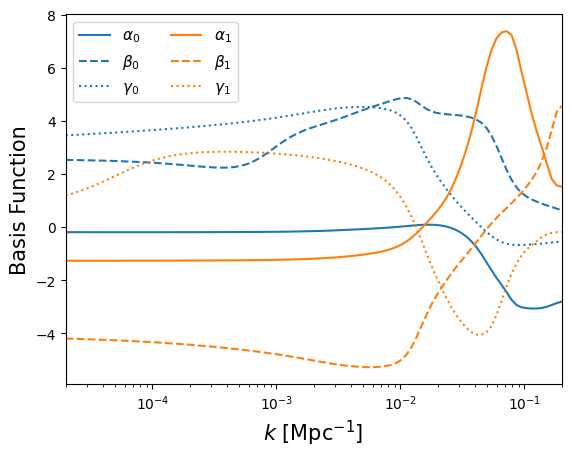

In [7]:
k_arr = np.geomspace(np.min(kk), np.max(kk), 100)
for i in range(num_terms):
    plt.plot(k_arr, alpha_k(k_arr,i), c=cm.tab10(i),ls='-',label=r'$\alpha_{%d}$'%i)
    plt.plot(k_arr, beta_k(k_arr,i), c=cm.tab10(i),ls='--',label=r'$\beta_{%d}$'%i)
    if symm_kind!=2:
        plt.plot(k_arr, gamma_k(k_arr,i), c=cm.tab10(i),ls=':',label=r'$\gamma_{%d}$'%i)
plt.xscale('log')
if log_transform:
    plt.yscale('log')
    plt.legend();
plt.xlabel(r'$k$ $[\mathrm{Mpc}^{-1}]$',fontsize=15);
plt.ylabel(r'Basis Function',fontsize=15);
plt.xlim(min(k_arr),max(k_arr));
plt.legend(ncol=2,fontsize=11);

Finally, we compare the true and inferred bispectra. We'll plot the bispectra in reduced coordinates: $x=k_1/k_3$ and $y=k_2/k_3$ for this (fixing $k_3$). The model predictions can depend slightly on $k_3$ since the scale-invariance does not hold precisely. In particular, modes with $k\approx k_{\rm max}$ may not be accurately reconstructed, since these are heavily downweighted in the observed CMB experiments, and thus the `separate-bk` code.

In [8]:
# Define the triangles 
x = np.linspace(kmin/kmax,1,50)
y = np.linspace(kmin/kmax,1,50)
k = np.linspace(kmin, kmax, 50)
XX, YY, KK = np.meshgrid(x,y,k)
# Assert triangle conditions
f = (np.abs(XX-YY)<=1.)*(1.<=XX+YY)*(XX<=YY)*(XX*KK>=kmin)
xx,yy,kk = XX[f].ravel(),YY[f].ravel(),KK[f].ravel()

# Define shapes on reduced grid
shapes_true = np.zeros_like(XX,dtype=np.float32)
shapes_nn = np.zeros_like(XX,dtype=np.float32)
shapes_true[f] = shape_function(xx*kk, yy*kk, kk, 'equil')
shapes_nn[f] = shape_model(xx*kk, yy*kk, kk).ravel()

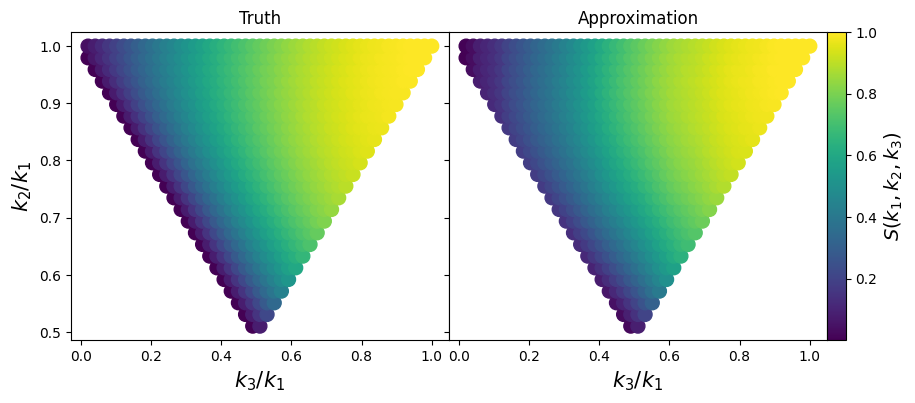

In [9]:
# Set up output 
fig = plt.figure(figsize=(10, 4))
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0)  # no horizontal gap
ax1 = fig.add_subplot(gs[0])
ax0 = fig.add_subplot(gs[1], sharex=ax1, sharey=ax1)

# Plot main data, fixing k_3 = kmax/2
filt = kk==(k[25])
minval, maxval = np.min(shapes_true[f][filt]), np.max(shapes_true[f][filt])
sc0 = ax0.scatter(xx[filt], yy[filt], c=shapes_nn[f][filt], vmin=minval, vmax=maxval,s=100)
sc1 = ax1.scatter(xx[filt], yy[filt], c=shapes_true[f][filt], vmin=minval, vmax=maxval,s=100)

# Add cosmetics
cax = fig.add_subplot(gs[2])
cb = fig.colorbar(sc1, cax=cax)
cb.set_label(r"$S(k_1,k_2,k_3)$", fontsize=14)
ax0.set_title('Approximation')
ax1.set_title('Truth')
ax0.set_xlabel(r'$k_3/k_1$',fontsize=15);
ax1.set_xlabel(r'$k_3/k_1$',fontsize=15);
ax1.set_ylabel(r'$k_2/k_1$',fontsize=15);
for a in (ax0, ax1): a.label_outer();

We can also compute the cosine between two shapes. In the main code, we use a modified inner product to reflect the sensitivity of current CMB experiments. Here, we'll use a simplified form for testing. As expected, the cosine is excellent!

In [10]:
def inner(shape1, shape2):
    """Compute the idealized inner product between shapes"""
    return scipy.integrate.simpson(k**2*scipy.integrate.simpson(scipy.integrate.simpson(shape1*shape2*f,x=x,axis=0),x=y,axis=0),x=k,axis=0)
def get_cosine(shape1, shape2):
    """Compute the idealized cosine between shapes"""
    inner11 = inner(shape1, shape1)
    inner12 = inner(shape1, shape2)
    inner22 = inner(shape2, shape2)
    return inner12/np.sqrt(inner11*inner22)

print("Cosine = %.2f%%"%(100*get_cosine(shapes_nn, shapes_true)))

Cosine = 99.54%


## 4. Computing CMB estimators

Next, we discuss how to use the factorized shape functions to build efficient CMB bispectrum estimators. For this, we'll use the `PolySpec` code. Full tutorials describing the usage of the code are available on [GitHub](https://github.com/oliverphilcox/PolySpec); here, we'll just describe the modifications needed to use the neural basis functions.

First, we define the basis functions and weights in an appropriate form.

In [11]:
# Define alpha_i(k), beta_i(k), gamma_i(k) functions
def alpha_k(_k, i):
    k = encoder(_k)
    if i==num_terms:
        return 1.+0.*k
    else:
        return f_x(loaded_model.model.alpha[i](k)).detach().numpy()
def beta_k(_k, i):
    k = encoder(_k)
    if i==num_terms:
        return 1.+0.*k
    else:
        return f_x(loaded_model.model.beta[i](k)).detach().numpy()

def gamma_k(_k, i):
    k = encoder(_k)
    if i==num_terms:
        return 1.+0.*k
    elif symm_kind==0:
        return 1./(alpha_k(_k,i)*beta_k(_k,i))
    elif symm_kind==1:
        return f_x(loaded_model.model.gamma[i](k)).detach().numpy()
    else:
        raise Exception("Not defined for symm-kind=%d"%symm_kind)

# Define the PolySpec inputs        
if symm_kind==1:
    neural_inputs = [all_weights, alpha_k, beta_k, gamma_k]
elif symm_kind==2:
    neural_inputs = [all_weights, alpha_k, beta_k]

Next, we load the PolySpec code and feed in the basis functions. Here, we'll use a simple problem for testing, restricting to low $\ell_{\rm max}$. The PolySpec code requires a range of input data -- here we use simplified versions for testing. A full description of the inputs and outputs can be found in the PolySpec repository.

There are two key changes to the PolySpec pipeline when adding the factorizable basis functions.
- We add "neural" to the list of input templates to analyze.
- We feed the `neural_inputs` to the PolySpec bispectrum class on initialization.

That's it! The rest of the code (preprocessing, optimization, computation of the normalization, and computation of the estimators) proceeds as usual. We caution that PolySpec is usually run on an HPC cluster, thus the code below may take a while to run...

First, we set-up the analysis, defining the input spectra, transfer functions, masks et cetera.

In [12]:
# Imports
import sys, camb, healpy
sys.path.append('/mnt/home/ophilcox/PolySpec/')
import polyspec as ps

# List of templates to analyze
templates = ["fNL-loc","neural"]
# Healpix resolution
Nside = 64

# Define a fiducial cosmology using CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=68, ombh2=0.022, omch2=0.12, tau=0.054, num_massive_neutrinos=1, mnu=0.06)
pars.InitPower.set_params(As=2.1e-9, ns=0.97, r=0, nt=0)
pars.set_for_lmax(800);
pars.set_accuracy(DoLateRadTruncation=False,AccuracyBoost=2,lSampleBoost=50,lAccuracyBoost=2);

# Compute a fiducial power spectrum
results = camb.get_results(pars);
cls = results.get_cmb_power_spectra(pars,raw_cl=True,CMB_unit='K')
cl_dict = {'TT':cls['lensed_scalar'][:3*Nside,0]}

# Compute a fiducial transfer function
trans = results.get_cmb_transfer_data('scalar')
ls, k_arr, transferT = trans.get_transfer(source=0);
ls = ls.astype(int)
transfer_arr = [np.vstack([[np.zeros_like(k_arr) for _ in range(2)],transferT[:3*Nside]*pars.TCMB])]

# Load base class, specifying the fiducial spectrum and beam
base = ps.PolySpec(Nside=Nside, Cl_tot=cl_dict, pol=False, backend="healpix")

# Load the analysis parameters (see the PolySpec code for more information!)
mask = np.ones(healpy.nside2npix(Nside))
Sinv = ps.weighting.Weightings(base, cl_dict).applySinv_ideal
lmin, lmax = 2, 100

Next, we load the main class, feeding in the factorizable basis functions and weights (as `neural_inputs`). We also perform numerical optimization to allow us to evaluate the estimator *very* fast.

In [13]:
# Load the bispectrum template class, specifying the templates to analyze
bspec = ps.BSpecTemplate(base, mask, Sinv, templates, lmin, lmax, 
                         k_arr, transfer_arr, neural_inputs=neural_inputs)

# Perform optimization to compute the radial integration points
bspec.optimize_radial_sampling_1d(verb=True);

Primordial Spectrum: n_s = 0.96, A_s = 2.10e-09, k_pivot = 0.05
l-range: [2, 100]
Polarizations: ['T']
Templates: ['fNL-loc', 'neural']
Using a neural network input with 2 terms
Mask: ones
# No input radial sampling points supplied; these can be computed with the optimize_radial_sampling_1d() function

# Computing k integrals with fiducial radial grid
N_k: 2681
N_r: 686
Precomputing Bessel functions
Interpolating Bessel functions
Computing q_l^X(r) integrals
Computing p_l^X(r) integrals
Computing f_l^X[alpha](r) integrals
Precomputation complete
Computing all Fisher matrix derivatives
	Computing fNL-loc Fisher matrix derivative exactly
	Computing neural Fisher matrix derivative exactly

Running optimization for template fNL-loc
Initial score: 1.41e-04
Iteration 1, relative score: 1.73e-01, old score: 1.00e+00
Iteration 2, relative score: 1.70e-03, old score: 1.73e-01
Iteration 3, relative score: 7.86e-04, old score: 1.70e-03

Score threshold met with 3 indices
Ideal fNL-loc Fisher: 1.4

Finally, we run the code to compute the estimator normalization matrix (equal to the Fisher matrix), and apply the code to a single test dataset. The outputs are the $f_{\rm NL}$ values -- importantly these include the $f_{\rm NL}$ amplitudes for the shape we performed a neural decomposition on above!

In [14]:
# Compute the Fisher matrix as a Monte Carlo sum over 3 realizations
fish = np.mean([bspec.compute_fisher_contribution(seed, verb=(seed==0)) for seed in range(10)],axis=0)

# Compute the optimal errorbars as the inverse Fisher matrix
fNL_errors = np.diag(np.linalg.inv(fish))**0.5

# Generate a test input dataset
data = base.generate_data()

# Compute the bispectrum estimator for some mock data
# We use 10 terms to compute the linear term in the estimator
bspec.generate_sims(10)
fNL_values = np.linalg.inv(fish)@bspec.Bl_numerator(data)

# Print run-time statistics
bspec.report_timings()

# Print outputs
print("Output fNL parameters")
for t in range(len(templates)):
    print("%s: %.0f +- %.0f"%(templates[t], fNL_values[t], fNL_errors[t]))

Computing Fisher matrix with seed 0
# Generating GRFs

# Computing Q3 map for S^-1 weighting
Weighting maps
Computing filtered maps
Creating Q maps
Creating P maps
Creating neural maps
Computing Q-derivative for fNL-loc
Computing Q-derivative for neural fNL

# Computing Q3 map for A^-1 weighting
Weighting maps
Computing filtered maps
Creating Q maps
Creating P maps
Creating neural maps
Computing Q-derivative for fNL-loc
Computing Q-derivative for neural fNL
Applying S^-1 weighting to output

# Assembling Fisher matrix


# Fisher matrix contribution 0 computed successfully!
Computing Fisher matrix with seed 1
Computing Fisher matrix with seed 2
Computing Fisher matrix with seed 3
Computing Fisher matrix with seed 4
Computing Fisher matrix with seed 5
Computing Fisher matrix with seed 6
Computing Fisher matrix with seed 7
Computing Fisher matrix with seed 8
Computing Fisher matrix with seed 9
Using 10 Monte Carlo simulations
Computing fNL-local template
Computing neural template

## Timi